# Unidad 4: Introducción a los modelos de pronóstico

## 4.1 Introducción

Abordaremos métodos de suavizamiento, buscando la aproximación cuantitativa del pronóstico de series temporales.

## 4.2 Objetivo

Conocer los modelos básicos de series de tiempo usando las técnicas apropiadas y comunes para ejemplificar las relaciones entre este tipo de datos. 

## 4.3 Acción

En esta ocasión, se debe aplicar la metodología Holter-Winter y de suavizamiento a la variable tiempo.  Se invita al estudiante en ser claro en sus procedimientos, ya que la forma de justificarlos será evaluada

### 4.3.1 Preparación de los datos

Previo al análisis detallado, es imperativo comprender el proceso de preparación de datos temporales para garantizar su idoneidad y coherencia en el estudio.

In [1]:
# importando librerias

# librerias para la transformación de datos
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# libreria para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

#### 4.3.1.1 Recopilación de los datos

En este bloque, se carga el conjunto de datos desde un archivo CSV utilizando la biblioteca pandas. Se especifica el delimitador de campos y se visualizan las primeras filas del dataframe para verificar que los datos se han cargado correctamente.

In [2]:
# recopilación de datos
df_data = pd.read_csv('./dataset.csv',sep=';')
df_data.head()

,fechaoperacion,codigo,contenido,hora1,hora2,hora3,hora4,hora5,hora6,hora7,...,hora15,hora16,hora17,hora18,hora19,hora20,hora21,hora22,hora23,hora24
0,1/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),87.778212,77.778212,77.778212,77.778212,77.778212,77.778212,75.768212,...,75.768212,71.278212,69.067212,76.278212,77.778212,87.778212,87.778212,77.778212,77.778212,77.778212
1,2/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),76.278212,76.278212,76.278212,76.278212,76.278212,76.778212,76.778212,...,82.778212,82.778212,82.778212,81.768212,87.778212,87.778212,87.778212,82.778212,76.778212,76.778212
2,3/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),77.678212,77.678212,77.678212,77.678212,77.678212,77.678212,77.678212,...,82.778212,82.778212,82.778212,82.778212,87.778212,114.425212,87.778212,82.778212,77.678212,77.678212
3,4/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),77.778212,77.778212,77.778212,77.778212,77.778212,77.778212,77.778212,...,77.778212,77.778212,77.778212,85.778212,85.778212,87.778212,85.778212,85.778212,81.768212,77.778212
4,5/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),86.778212,86.778212,86.778212,86.778212,86.778212,86.778212,88.278212,...,88.278212,88.278212,88.278212,88.278212,88.278212,91.134212,88.278212,88.278212,86.778212,86.778212


#### 4.3.1.2 Transformación de Datos

Este bloque define una función para transformar el dataframe original. Se realiza una copia del dataframe, se convierte la columna de fechas a un formato de fecha adecuado, y se agregan nuevas columnas para el año, mes y día. Luego, se seleccionan y reorganizan las columnas, y finalmente, se pivotea la tabla para facilitar su uso en análisis posteriores.

In [3]:
def trf_data(df_data):
    
    # copia del dataframe
    df = df_data.copy()
    
    # transformación de fechas
    df['fechaoperacion'] = pd.to_datetime(df['fechaoperacion'], format='%d/%m/%Y')
    
    # agregando las columnas de fechas
    df['ano'] = df.apply(lambda x: x['fechaoperacion'].year ,axis=1)
    df['mes'] = df.apply(lambda x: x['fechaoperacion'].month ,axis=1)
    df['dia'] = df.apply(lambda x: x['fechaoperacion'].day ,axis=1)
    
    # selección de columnas
    df = df[['fechaoperacion','ano','mes','dia', 'hora1', 'hora2', 'hora3','hora4', 'hora5', 'hora6', 'hora7', 'hora8', 'hora9', 'hora10','hora11', 'hora12', 'hora13', 'hora14', 'hora15', 'hora16', 'hora17','hora18', 'hora19', 'hora20', 'hora21', 'hora22', 'hora23', 'hora24']]
    
    # Convertir la tabla
    list_id = [i.lower() for i in df.columns if not 'hora' in i]
    list_value = [i.lower() for i in df.columns if 'hora' in i]
    
    # pivotear la tabla
    df = df.melt(id_vars=list_id,value_vars=list_value,var_name='periodo',value_name='valor')
    
    return df

In [4]:
# dataset trasnformado
df = trf_data(df_data)
df.head()

,fechaoperacion,ano,mes,dia,periodo,valor
0,2006-01-01,2006,1,1,hora1,87.778212
1,2006-01-02,2006,1,2,hora1,76.278212
2,2006-01-03,2006,1,3,hora1,77.678212
3,2006-01-04,2006,1,4,hora1,77.778212
4,2006-01-05,2006,1,5,hora1,86.778212


#### 4.3.1.3 Remuestreo de la serie temporal

En este bloque, se crea una copia del dataframe transformado y se remuestrean los datos a valores mensuales. Se agrupan los datos por fecha y se calcula la media mensual. Luego, se seleccionan las columnas relevantes y se visualiza el nuevo dataframe remuestreado.

In [5]:
# remuestreando la serie de tiempo a valores mensuales

# creando una copia del dataframe
df_vcm = df.copy()

#  remuestreando el dataframe a mensual
df_vcm = df_vcm.resample('M',on='fechaoperacion').mean().reset_index()
df_vcm = df_vcm[['fechaoperacion','valor']]

# mostrando el dataframe transformado
df_vcm.head()

,fechaoperacion,valor
0,2006-01-31,79.026486
1,2006-02-28,75.520919
2,2006-03-31,65.787447
3,2006-04-30,54.012347
4,2006-05-31,53.819582


### 4.3.2 Visualización y Creación de la Serie Temporal

Se realizarán dos tareas fundamentales: la visualización de la serie temporal y la estimación de su tendencia mediante técnicas de suavizamiento, así como la creación de una serie temporal para el análisis con la metodología Holt-Winters.

#### 4.3.2.1 Visualización y Suavizamiento de la Serie Temporal

Primero, se grafica la serie de tiempo con los datos remuestreados a valores mensuales. Se utiliza la técnica de suavizamiento LOWESS (Locally Weighted Scatterplot Smoothing) para estimar la tendencia de la serie temporal. LOWESS es un método no paramétrico que ajusta múltiples regresiones locales, proporcionando una estimación suave de la tendencia subyacente.

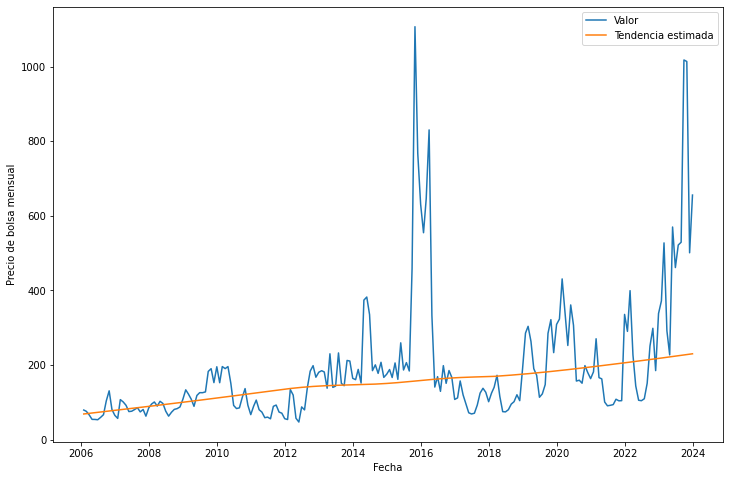

In [6]:
# Graficar la serie de tiempo y su tendencia estimada
plt.figure(figsize=(12, 8))
plt.plot(df_vcm['fechaoperacion'], df_vcm['valor'], label='Valor')
lowess = sm.nonparametric.lowess
smoothed = lowess(df_vcm['valor'], df_vcm['fechaoperacion'])
plt.plot(df_vcm['fechaoperacion'], smoothed[:, 1], label='Tendencia estimada')
plt.xlabel('Fecha')
plt.ylabel('Precio de bolsa mensual')
plt.legend()
plt.show()

### 4.3.3 Aplicación de la metodología Holt-Winters

En esta sección, se detalla la aplicación de la metodología Holt-Winters para el pronóstico de series temporales. Este método es particularmente útil para series con tendencia y estacionalidad. A continuación, se justifica cada procedimiento y se presenta el código correspondiente.

#### 4.3.3.1 Creación de la Serie Temporal

A continuación, se crea una serie temporal utilizando los valores mensuales transformados. Esto es esencial para aplicar modelos de pronóstico, como la metodología Holt-Winters. Holt-Winters es una técnica de suavizamiento exponencial que considera la tendencia y la estacionalidad de los datos, y es particularmente útil para series temporales con patrones estacionales y tendencias

El boxplot mensual ayuda a identificar patrones estacionales y posibles anomalías en los datos. Esta visualización es crucial para decidir sobre el tratamiento de la estacionalidad en el modelo Holt-Winters.

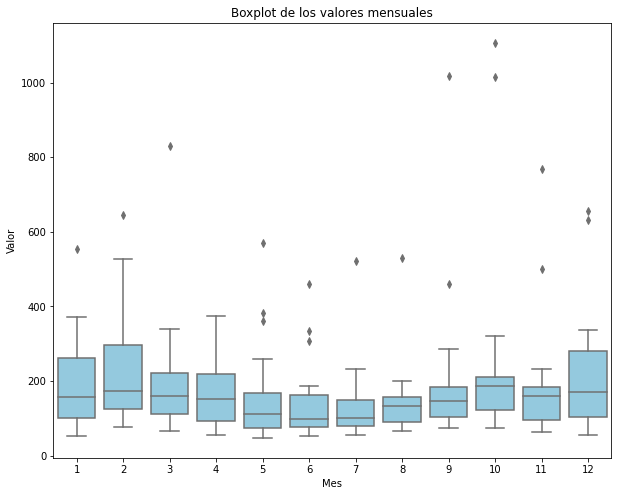

In [7]:
# Crear una serie temporal
precio_ts = pd.Series(df_vcm['valor'].values, index=pd.date_range(start='2006-01', periods=len(df_vcm), freq='M'))

# Crear un boxplot de los datos
plt.figure(figsize=(10, 8))
sns.boxplot(x=precio_ts.index.month, y=precio_ts.values,color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Valor')
plt.title('Boxplot de los valores mensuales')
plt.show()

#### 4.3.3.2 Estabilización de la Variabilidad

Para estabilizar la variabilidad, se aplica una transformación logarítmica a la serie temporal. Luego, se ajusta un modelo Holt-Winters que considera tanto la tendencia como la estacionalidad aditivas.

La transformación logarítmica se utiliza para estabilizar la variabilidad y hacer que los datos sean más apropiados para el modelado. El método Holt-Winters se elige por su capacidad para manejar tanto la tendencia como la estacionalidad, factores identificados en la serie temporal. La impresión de los parámetros del modelo proporciona transparencia y permite verificar el ajuste del modelo.

c:\users\uenergia\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


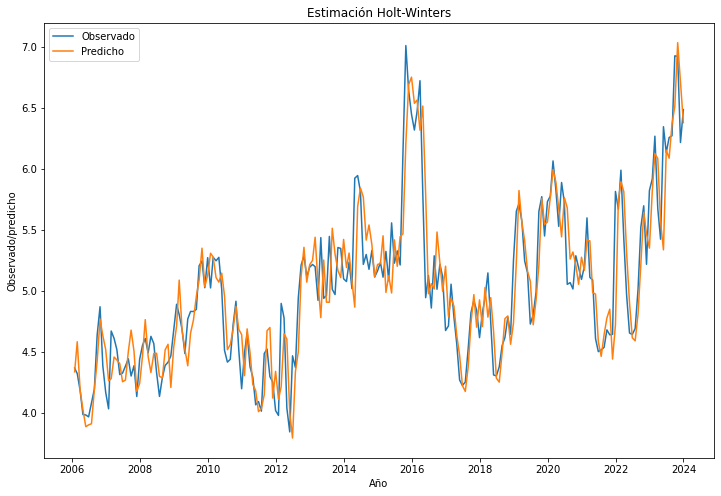

In [8]:
# Estabilización de la variabilidad
preciolog = np.log(precio_ts)

# Aplicación del método Holt-Winters
model = ExponentialSmoothing(preciolog, seasonal_periods=12, trend='add', seasonal='add')
fit = model.fit()

# Graficar los resultados
plt.figure(figsize=(12, 8))
plt.plot(preciolog, label='Observado')
plt.plot(fit.fittedvalues, label='Predicho')
plt.title("Estimación Holt-Winters")
plt.xlabel('Año')
plt.ylabel('Observado/predicho')
plt.legend()
plt.show()

#### 4.3.3.3 Predicción del Modelo

Finalmente, se utiliza el modelo ajustado para predecir los valores de la serie temporal para el próximo año (12 meses). Se grafican las observaciones originales, los valores ajustados por el modelo, y las predicciones.

La predicción para el próximo año permite evaluar la capacidad del modelo para generalizar y prever futuros valores. Graficar las observaciones originales junto con los valores ajustados y predichos facilita la comparación visual y la validación del modelo.

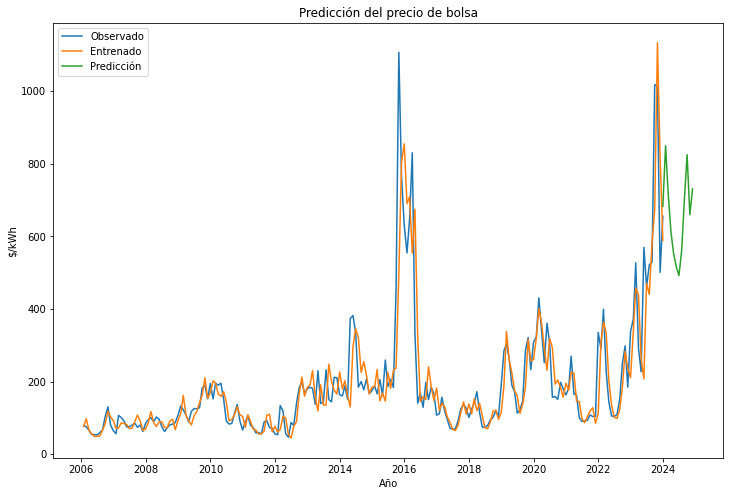

In [9]:
# Predicción del siguiente año
forecast_next_year = fit.forecast(steps=12)

# Convertir los valores predichos y las predicciones a la escala original
fittedvalues_original = np.exp(fit.fittedvalues)
forecast_next_year_original = np.exp(forecast_next_year)

# Graficar los resultados en la escala original
plt.figure(figsize=(12, 8))
plt.plot(precio_ts, label='Observado')
plt.plot(fittedvalues_original, label='Entrenado')
plt.plot(pd.date_range(start=precio_ts.index[-1], periods=12, freq='M'), forecast_next_year_original, label='Predicción')
plt.title("Predicción del precio de bolsa")
plt.xlabel('Año')
plt.ylabel('$/kWh')
plt.legend()
plt.show()

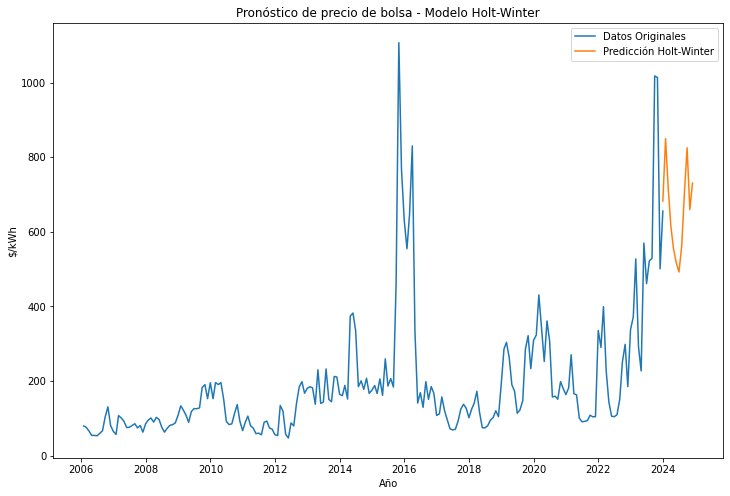

In [10]:
# Graficar los resultados en la escala original
plt.figure(figsize=(12, 8))
plt.plot(precio_ts, label='Datos Originales')
plt.plot(pd.date_range(start=precio_ts.index[-1], periods=12, freq='M'), forecast_next_year_original, label='Predicción Holt-Winter')
plt.title("Pronóstico de precio de bolsa - Modelo Holt-Winter")
plt.xlabel('Año')
plt.ylabel('$/kWh')
plt.legend()
plt.show()

### 4.3.4 Evalaución del Modelo

En esta sección, se evalúa el desempeño del modelo Holt-Winters utilizando dos métricas comunes: el Error Cuadrático Medio (MSE) y el Error Absoluto Medio (MAE). Estas métricas proporcionan una medida cuantitativa de qué tan bien se ajustan las predicciones del modelo a los datos reales.

Error Cuadrático Medio (MSE)
El Error Cuadrático Medio (MSE) calcula el promedio de los errores al cuadrado entre las predicciones y los datos reales. Un MSE más bajo indica un mejor ajuste del modelo a los datos observados.

Error Absoluto Medio (MAE)
El Error Absoluto Medio (MAE) calcula el promedio de las diferencias absolutas entre las predicciones y los datos reales. Es una medida de la magnitud promedio de los errores en las predicciones del modelo.

**Resultados de la Evaluación:**

- Error Cuadrático Medio (MSE): 0.2243
- Error Absoluto Medio (MAE): 0.3502

Estos valores proporcionan una indicación del rendimiento del modelo Holt-Winters en la predicción de los últimos 12 meses de la serie temporal. Un MSE y MAE más bajos indican un mejor ajuste del modelo a los datos de prueba.

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Selecciona un conjunto de datos de prueba
test_data = preciolog[-12:]  # Supongamos que los últimos 12 meses son el conjunto de prueba

# Realiza la predicción para estos datos de prueba
forecast_next_year = fit.forecast(steps=12)

# Calcula el Error Cuadrático Medio (MSE)
mse = mean_squared_error(test_data, forecast_next_year)

# Calcula el Error Absoluto Medio (MAE)
mae = mean_absolute_error(test_data, forecast_next_year)

print("Error Cuadrático Medio (MSE):", mse)
print("Error Absoluto Medio (MAE):", mae)

Error Cuadrático Medio (MSE): 0.22430213960370213
Error Absoluto Medio (MAE): 0.35016947773733853


### 4.3.5 Conclusión

Se realizó un análisis de una serie temporal utilizando la metodología Holt-Winters. Se han aplicado técnicas de preparación de datos, suavizamiento y modelado para comprender y predecir los patrones en los datos de precios de bolsa mensuales.

La aplicación de la metodología Holt-Winters se justifica plenamente por la presencia de estacionalidad y tendencia en los datos. Cada paso del proceso, desde la visualización inicial hasta la predicción, es crucial para garantizar un modelo robusto y transparente. Este enfoque sistemático no solo mejora la precisión del modelo, sino que también proporciona una base sólida para la interpretación y toma de decisiones basadas en los resultados del análisis. 

El análisis demuestra cómo un enfoque estructurado y bien justificado en la preparación y modelado de datos temporales puede conducir a resultados precisos y útiles, permitiendo una comprensión profunda de las dinámicas subyacentes en la serie temporal y proporcionando herramientas valiosas para la predicción y planificación futura.

Tras la evaluación del modelo Holt-Winters, se ha encontrado que presenta un buen ajuste a los datos, como se evidencia en los resultados de las métricas de evaluación. Con un Error Cuadrático Medio (MSE) de 0.2243 y un Error Absoluto Medio (MAE) de 0.3502, el modelo logra predecir con precisión los valores futuros de la serie temporal.

Estos hallazgos sugieren que el modelo Holt-Winters es una herramienta efectiva para la predicción de series temporales con patrones estacionales y tendencias.

Este estudio proporciona una sólida base para comprender y predecir la dinámica de los precios de bolsa mensuales, lo que puede ser de gran utilidad para la toma de decisiones.